# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Wed May  3 11:12:10 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-03 11:12:13


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [5]:
#run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number  = 3733
#run_number  = 3741
#run_number = 3753
#run_number = 3756
#run_number = 3758
#run_number = 3762
#run_number = 3767
#run_number = 3769
#run_number = 3772
#run_number = 3774
run_number = 3782




In [6]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [7]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3782/dst_3782.root.h5


In [8]:
full = load_dst(ifile)
print(len(full))
full.head()

8421


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,4,1.493319e+09,0,1,375.0,304.307343,1794.751344,283675.0,21.825000,4719.540039,...,655537.5,11,371.8625,371.8625,-77.904085,-155.064522,173.534009,-2.036360,9.294994,7.485093
1,5,1.493319e+09,0,1,300.0,250.052063,1455.152739,515375.0,11.556875,10277.833008,...,654187.5,20,138.8125,138.8125,-42.920109,138.865711,145.347244,1.870559,9.267552,9.383519
2,8,1.493319e+09,0,1,300.0,268.447021,1486.422525,507250.0,5.966687,1429.100830,...,653237.5,5,145.9875,145.9875,-199.038676,-57.194334,207.093183,-2.861779,4.914250,6.641327
3,11,1.493319e+09,0,1,325.0,270.010681,1533.954337,379250.0,12.026250,5816.912109,...,654937.5,21,275.6875,275.6875,115.207394,-84.769084,143.033357,-0.634348,9.918482,9.862439
4,12,1.493319e+09,0,1,300.0,303.672821,1736.613508,306525.0,10.689562,2125.184082,...,654787.5,9,348.2625,348.2625,197.404005,-37.783535,200.987404,-0.189115,6.854801,8.124655


In [9]:
msc = full[full.S2e  >  400*units.pes * 11] # michel sorel cuts
msc = msc [msc.S1e   >   100*units.pes * 11] 
msc = msc [msc.S2w   > 3.5] # units of mus!!!
msc = msc [msc.S2w   <  25] # units of mus!!! 
msc = msc [msc.S1w   >  300*units.ns]
msc = msc [msc.S1w   < 1000*units.ns] 
msc = msc [msc.S1t   >  100*units.mus]
msc = msc [msc.S2t   <  700*units.mus]

msc = msc [msc.R     <  100*units.mm] # fidc

large_drift = full[full.DT > 530]



In [10]:
len(full)

8421

In [11]:
r = event_rate(full)

In [12]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 1.9540296030521893 evts/s


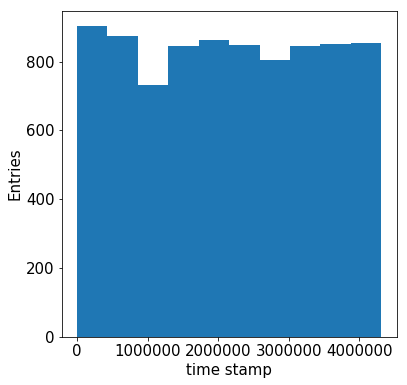

In [13]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

In [14]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

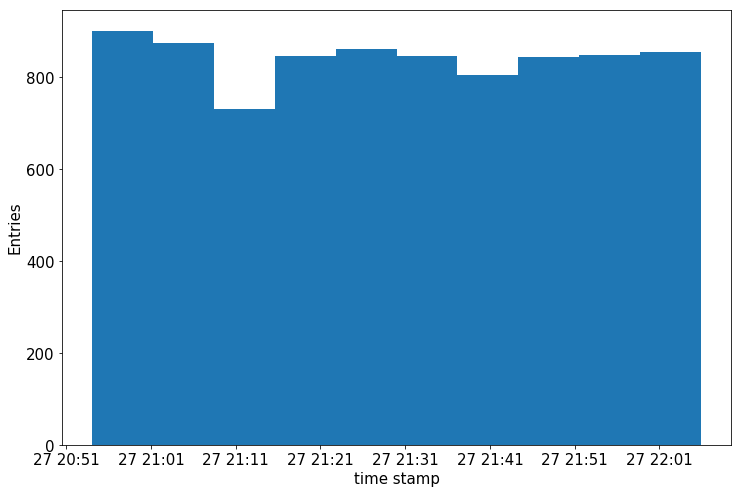

In [15]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [16]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [17]:
print(st)

2017-04-27 22:05:53


In [18]:
print(full.time.index[-1])

8420


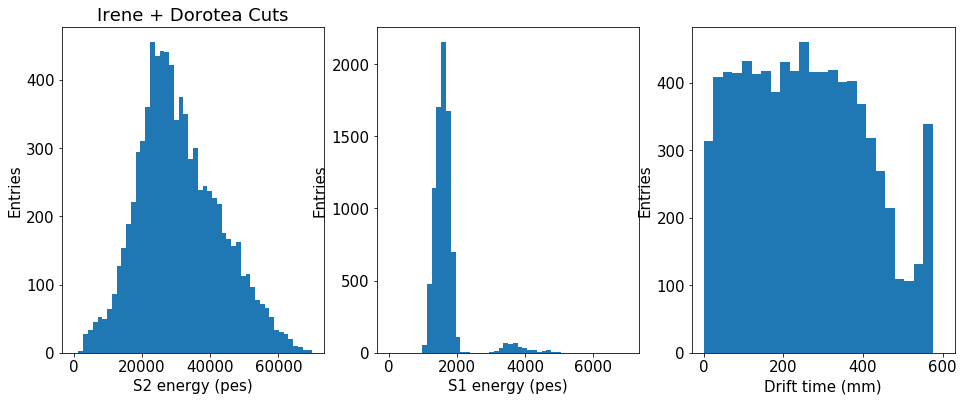

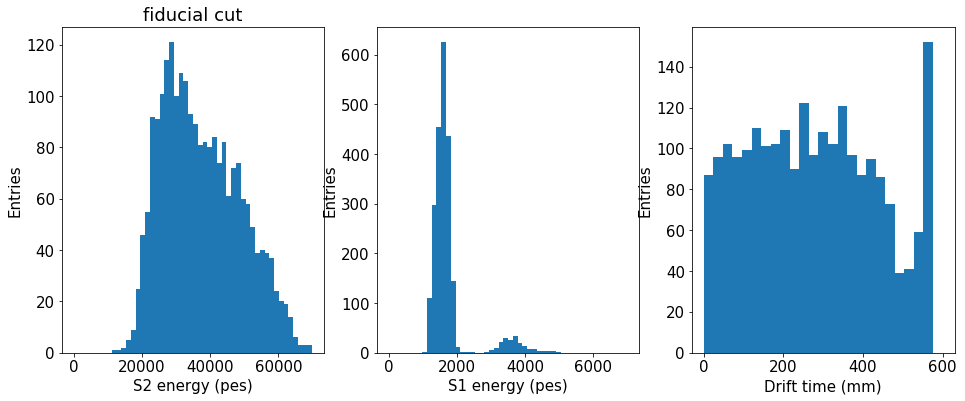

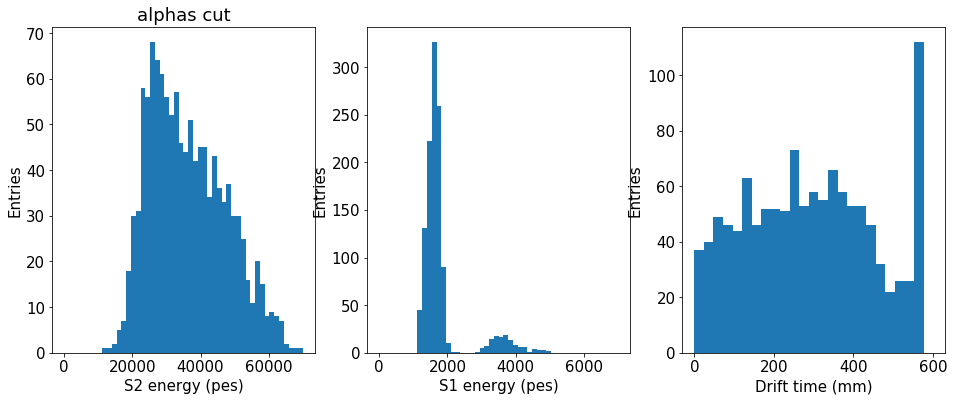

In [19]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fidc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fiducial cut')

ax = plt.subplot(1, 3, 2)
plt.hist(fidc.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(fidc.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(msc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('alphas cut')

ax = plt.subplot(1, 3, 2)
plt.hist(msc.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(msc.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

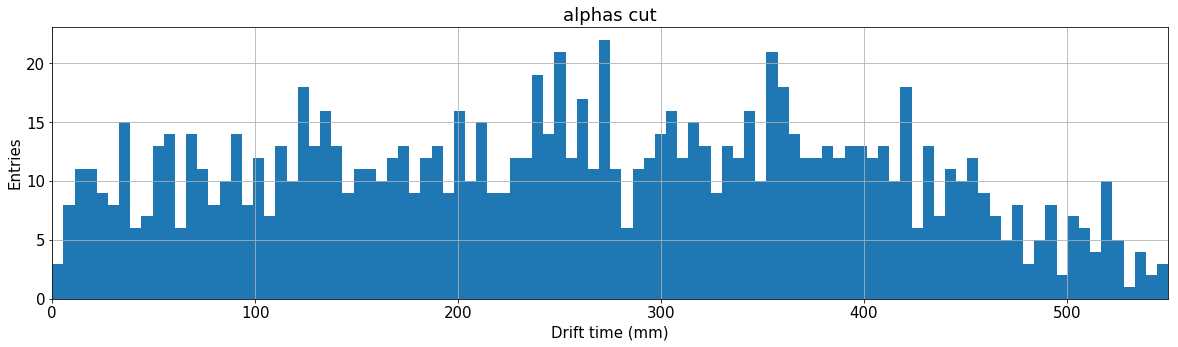

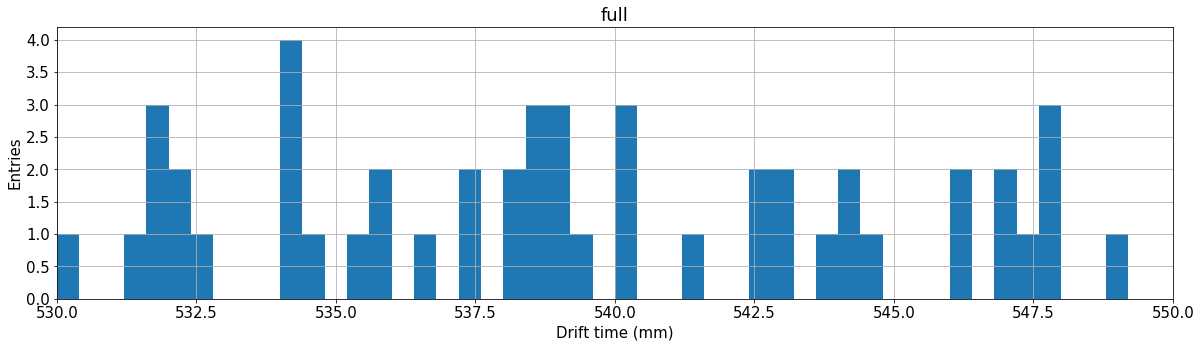

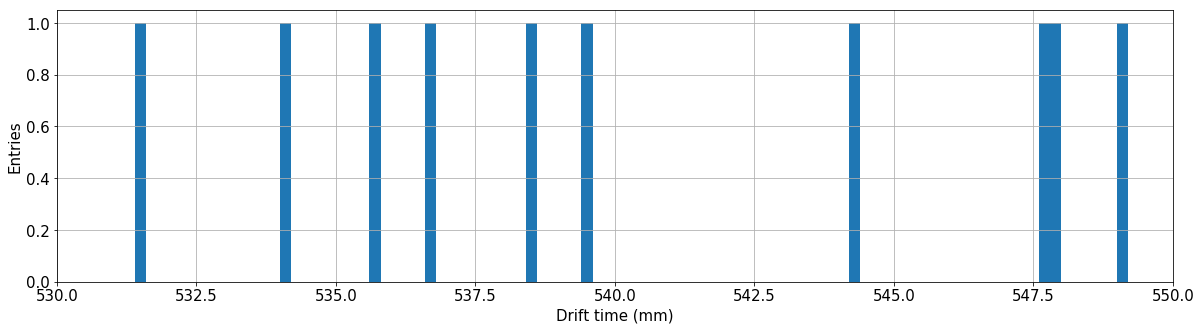

In [20]:
plt.figure(figsize=(20,5))
b = plt.hist(msc.Z, 100, (0, 550))
plt.xlim(0,550)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('alphas cut')




plt.figure(figsize=(20,5))
a = plt.hist(full[full.Z > 530].Z, 50, (530, 550))
plt.xlim(530,550)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('full')


    

plt.figure(figsize=(20,5))
b = plt.hist(msc[msc.Z > 530].Z, 100, (530, 550))
plt.xlim(530,550)
plt.grid(True)
labels("Drift time (mm)", "Entries")
#plt.title('alphas cut')



In [21]:
print(a)
print(b)

(array([ 1.,  0.,  0.,  1.,  3.,  2.,  1.,  0.,  0.,  0.,  4.,  1.,  0.,
        1.,  2.,  0.,  1.,  0.,  2.,  0.,  2.,  3.,  3.,  1.,  0.,  3.,
        0.,  0.,  1.,  0.,  0.,  2.,  2.,  0.,  1.,  2.,  1.,  0.,  0.,
        0.,  2.,  0.,  2.,  1.,  3.,  0.,  0.,  1.,  0.,  0.]), array([ 530. ,  530.4,  530.8,  531.2,  531.6,  532. ,  532.4,  532.8,
        533.2,  533.6,  534. ,  534.4,  534.8,  535.2,  535.6,  536. ,
        536.4,  536.8,  537.2,  537.6,  538. ,  538.4,  538.8,  539.2,
        539.6,  540. ,  540.4,  540.8,  541.2,  541.6,  542. ,  542.4,
        542.8,  543.2,  543.6,  544. ,  544.4,  544.8,  545.2,  545.6,
        546. ,  546.4,  546.8,  547.2,  547.6,  548. ,  548.4,  548.8,
        549.2,  549.6,  550. ]), <a list of 50 Patch objects>)
(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  

### Dependence with Z all alphas

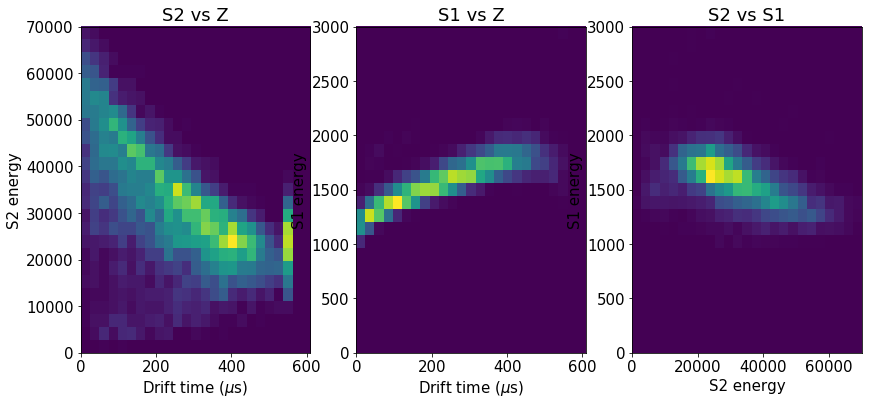

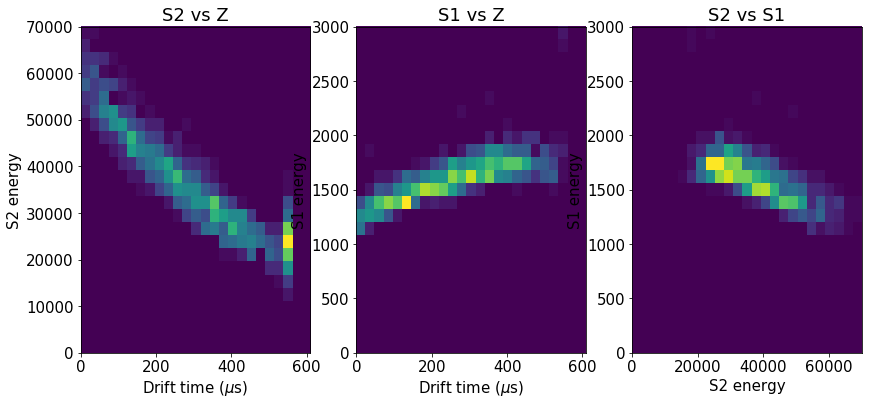

In [22]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(msc.Z, msc.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(msc.Z, msc.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(msc.S2e, msc.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [23]:
#core = blk[blk.R < 100]
core = full[full.R < 100]
print("Ratio wrt full:", len(core)/len(full))


core2 = full[full.Z > 300]
core2 = core2[core2.Z < 500]

#core= msc

Ratio wrt full: 0.269682935518347


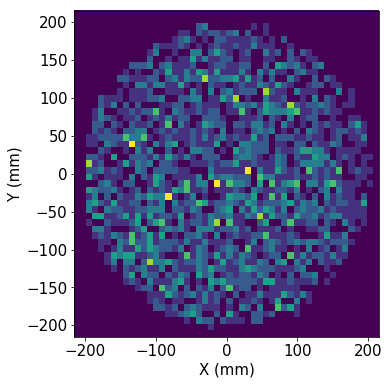

In [24]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(core2.X, core2.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")



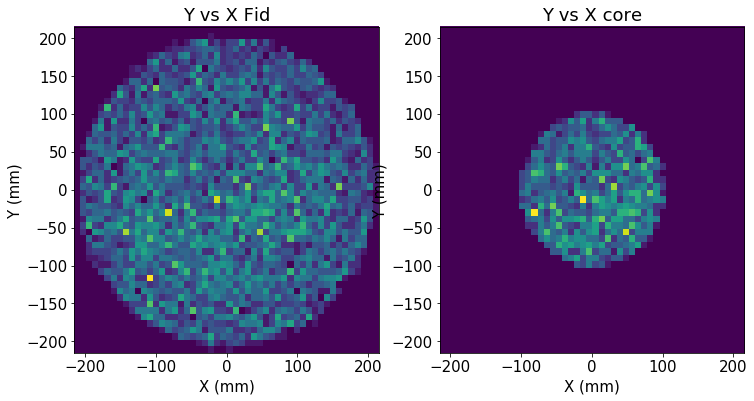

In [25]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

### Z correction for bulk 

#### S2

fit par[0] = 60372.471900927034 error = 325.56285151864626
fit par[1] = -518.3858227588844 error = 6.43077746113772
degrees of freedom = 2
chi2 = 1.0268182703961388


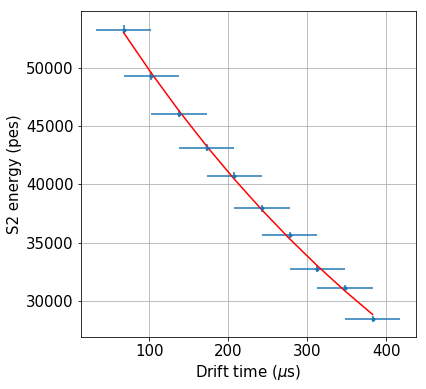

In [26]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [27]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.17931362071012943


#### Fit S2 in fiducial 

fit par[0] = 60372.471900927034 error = 325.56285151864626
fit par[1] = -518.3858227588844 error = 6.43077746113772
degrees of freedom = 2
chi2 = 1.0268182703961388


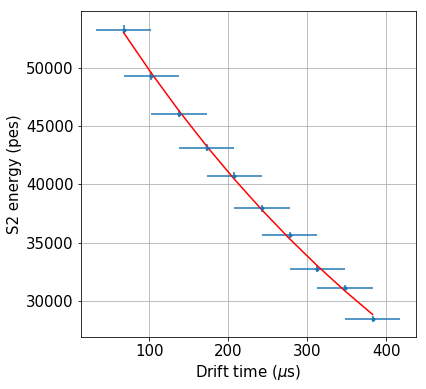

In [28]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [29]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-04-27 20:54:04 t1 = 2017-04-27 22:05:53


In [30]:
len(cz)

1510

using data set with length 1510
t0 = 2017-04-27 20:54:08 (index = 0) t1 = 2017-04-27 22:05:52 (index = 1510)
bin length = 503
 ---fit over events between 0 and 503
time0 = 2017-04-27 20:54:08 time1 = 2017-04-27 21:18:22
size of time leg = 503
fit par[0] = 64026.280621068145 error = 225.3671258187873
fit par[1] = -521.8241091205673 error = 4.094456999899934
degrees of freedom = 2
chi2 = 0.45984944589287885
 ---fit over events between 503 and 1006
time0 = 2017-04-27 21:18:22 time1 = 2017-04-27 21:42:33
size of time leg = 503
fit par[0] = 59627.83441594634 error = 417.74099710878875
fit par[1] = -517.0139270219399 error = 7.91928912278155
degrees of freedom = 2
chi2 = 1.0257327670174081
 ---fit over events between 1006 and 1509
time0 = 2017-04-27 21:42:33 time1 = 2017-04-27 22:05:52
size of time leg = 503
fit par[0] = 58196.41675023761 error = 430.60156065266807
fit par[1] = -506.59551260664887 error = 8.671510764894942
degrees of freedom = 2
chi2 = 1.175545343516661


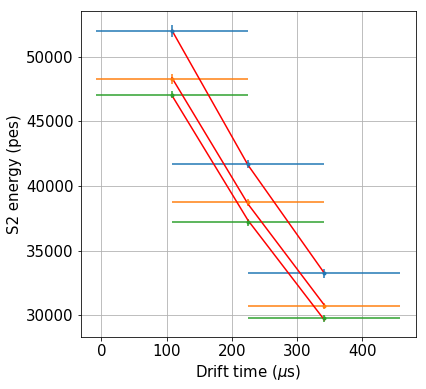

In [31]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(50,400), Erange=(1e+3, 80e3), nbins=3)

In [32]:
plot_options()

In [33]:
TSTAMP

['2017-04-27 21:18:22', '2017-04-27 21:42:33', '2017-04-27 22:05:52']

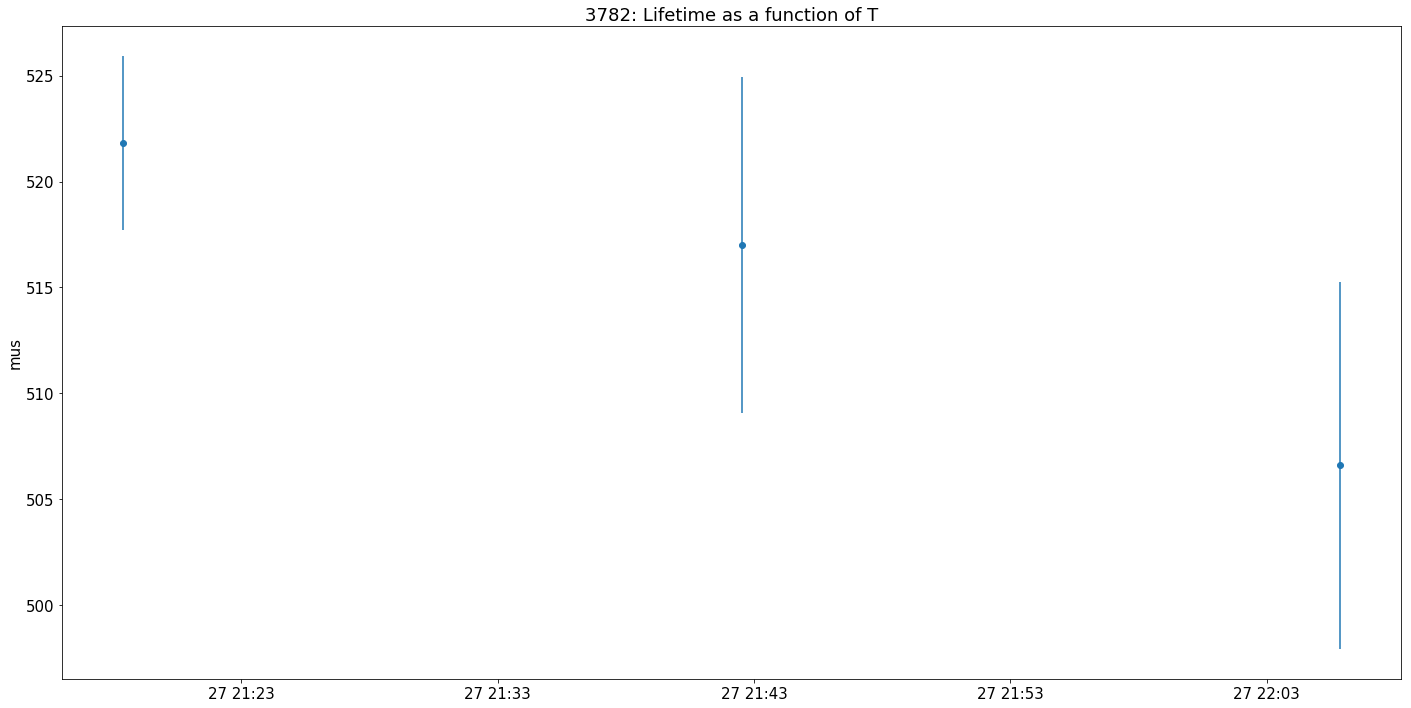

In [34]:
figsize=(24,12)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))
plt.show()

In [35]:
print(-np.array(LAMBDA)[-1], np.array(ELAMBDA)[-1])


506.595512607 8.67151076489


In [44]:
plog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/')

pfiles = [
          plog + 'GAS_Log_2017-04-15.txt',
          plog + 'GAS_Log_2017-04-16.txt',
          plog + 'GAS_Log_2017-04-17.txt',
          plog + 'GAS_Log_2017-04-18.txt',
          plog + 'GAS_Log_2017-04-19.txt',
          plog + 'GAS_Log_2017-04-20.txt',
          plog + 'GAS_Log_2017-04-21.txt',
          plog + 'GAS_Log_2017-04-22.txt',
          plog + 'GAS_Log_2017-04-23.txt',
          plog + 'GAS_Log_2017-04-24.txt',
          plog + 'GAS_Log_2017-04-25.txt',
          plog + 'GAS_Log_2017-04-26.txt',
          plog + 'GAS_Log_2017-04-27.txt',
          plog + 'GAS_Log_2017-04-28.txt',
          plog + 'GAS_Log_2017-04-29.txt',
          plog + 'GAS_Log_2017-04-30.txt',
          plog + 'GAS_Log_2017-05-01.txt',
          plog + 'GAS_Log_2017-05-02.txt'
        ]

print(pfiles)

['/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-15.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-16.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-17.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-18.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-19.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-20.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-21.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-22.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-23.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-24.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-25.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-26.txt', '/Users/alej/Desktop/IC_DAT

In [45]:
f0 = pd.read_csv(pfiles[0], skiprows=2, sep=None, engine='python', decimal=",")
f0

,Date,Hour,VG1,VG2,VG3,VG4,PG1,PG2,PG3,PG4,PG5,PG6,PGR2.2
0,15/04/2017,0:00:19,0.000020,0.000003,0.000001,1.937365,-0.133545,9.675583,6.942719,9.101624,6.696808,6.138596,7.672455
1,15/04/2017,0:00:50,0.000020,0.000003,0.000001,1.937365,-0.134079,9.639053,6.937912,9.081482,6.706039,6.171326,7.675812
2,15/04/2017,0:01:20,0.000020,0.000003,0.000001,1.937365,-0.130875,9.581650,6.950729,9.091553,6.659882,6.236786,7.672455
3,15/04/2017,0:01:51,0.000020,0.000003,0.000001,1.937365,-0.135681,9.670364,6.939514,9.059662,6.692612,6.274551,7.668259
4,15/04/2017,0:02:22,0.000020,0.000003,0.000001,1.937138,-0.136749,9.628616,6.936844,9.054626,6.687576,6.194824,7.669098
5,15/04/2017,0:02:52,0.000021,0.000003,0.000001,1.937365,-0.139420,9.748642,6.948593,9.055466,6.707718,6.141113,7.674133
6,15/04/2017,0:03:22,0.000020,0.000003,0.000001,1.937592,-0.131943,9.487717,6.949661,9.062180,6.677505,6.157898,7.669098
7,15/04/2017,0:03:53,0.000020,0.000003,0.000001,1.937365,-0.134613,9.769516,6.942719,9.048752,6.676666,6.215805,7.669098
8,15/04/2017,0:04:23,0.000020,0.000003,0.000001,1.937365,-0.132477,9.560776,6.955002,9.063019,6.668274,6.281265,7.673294
9,15/04/2017,0:04:54,0.000020,0.000003,0.000001,1.937365,-0.137283,9.837357,6.948059,9.064697,6.680023,6.354279,7.669098


In [47]:
#f = pd.read_csv(ppath, skiprows=2, sep=None, engine='python')

T  =[]
pg3=[]
pg6=[]
for f in pfiles: 
    f = pd.read_csv(f, skiprows=2, sep=None, engine='python')

    for d, t, g3, g6 in zip(f['Date'].values, f['Hour'].values, f['PG3'].values, f['PG6'].values):
        if len(t)==7: t = '0' + t
        T.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        pg3.append(g3)
        pg6.append(g6)
    print(len(T),len(pg3))


2843 2843
5688 5688
8532 8532
11637 11637
14483 14483
17325 17325
20170 20170
23016 23016
25860 25860
28544 28544
31380 31380
34233 34233
37086 37086
39944 39944
42804 42804
45665 45665
48521 48521
51376 51376


NameError: name 'r3645' is not defined

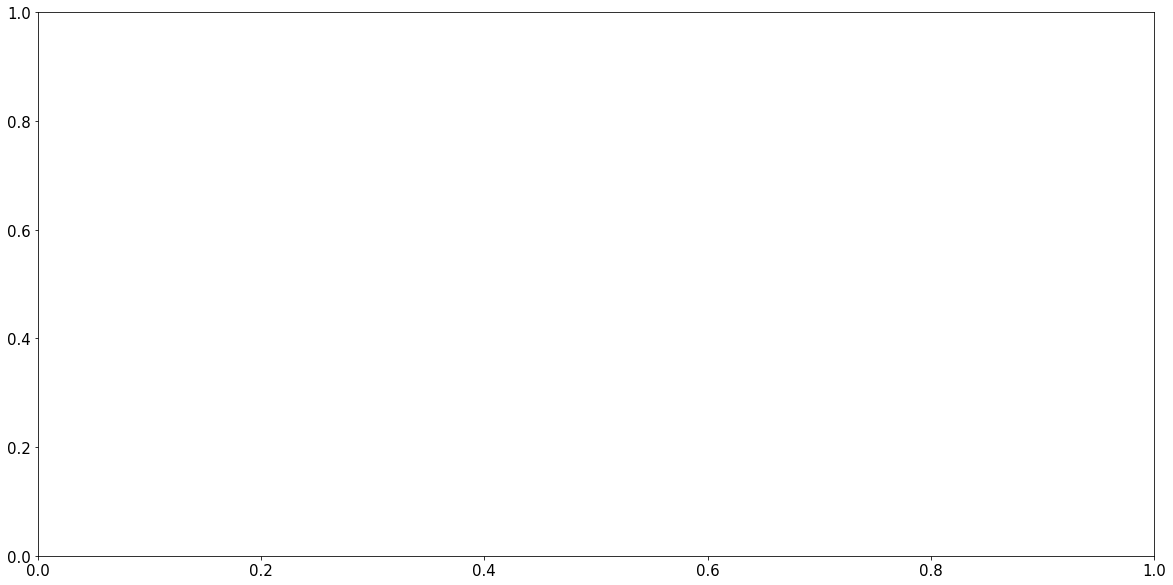

In [39]:
fig, ax1 = plt.subplots(figsize=(20, 10))
#ax1.errorbar(TIME[1:], -np.array(LAMBDA)[1:], yerr=ELAMBDA[1:], linestyle='none', fmt='o', c='r')
#r3741 = (TIME, -np.array(LAMBDA), ELAMBDA)
#r3741 = (TIME[1:], -np.array(LAMBDA)[1:], ELAMBDA[1:])
ax1.errorbar(r3645[0], r3645[1], yerr=r3645[2], linestyle='none', fmt='o', c='r', label='3645')
ax1.errorbar(r3715[0], r3715[1], yerr=r3715[2], linestyle='none', fmt='o', c='g', label='3715')
ax1.errorbar(r3724[0], r3724[1], yerr=r3724[2], linestyle='none', fmt='o', c='b', label='3724')
ax1.errorbar(r3733[0], r3733[1], yerr=r3733[2], linestyle='none', fmt='o', c='black', label='3733')
ax1.errorbar(r3741[0], r3741[1], yerr=r3741[2], linestyle='none', fmt='o', c='gold', label='3741')

plt.legend(loc=2)
ax1.set_ylabel('Lifetime (mus)')
ax2=ax1.twinx()
ax2.plot(T, pg3,alpha=.2, label='asdf')
ax2.set_ylabel('bar')
plt.title('PG3 and lifetime')
plt.grid(True)
plt.show()

In [53]:
days = 30
tlog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/temperature/Data/')
tfiles = [tlog + 'PWR_Data_Report_2017-04-15.txt',
          tlog + 'PWR_Data_Report_2017-04-16.txt',
          tlog + 'PWR_Data_Report_2017-04-17.txt',
          tlog + 'PWR_Data_Report_2017-04-18.txt',
          tlog + 'PWR_Data_Report_2017-04-19.txt',
          tlog + 'PWR_Data_Report_2017-04-20.txt',
          tlog + 'PWR_Data_Report_2017-04-21.txt',
          tlog + 'PWR_Data_Report_2017-04-22.txt',
          tlog + 'PWR_Data_Report_2017-04-23.txt',
          tlog + 'PWR_Data_Report_2017-04-24.txt',
          tlog + 'PWR_Data_Report_2017-04-25.txt',
          tlog + 'PWR_Data_Report_2017-04-26.txt',
          tlog + 'PWR_Data_Report_2017-04-27.txt',
          tlog + 'PWR_Data_Report_2017-04-28.txt',
          tlog + 'PWR_Data_Report_2017-04-29.txt',
          tlog + 'PWR_Data_Report_2017-04-30.txt',
          tlog + 'PWR_Data_Report_2017-05-01.txt',
          tlog + 'PWR_Data_Report_2017-05-02.txt']

In [54]:
f0 = pd.read_csv(tfiles[0], skiprows=2, sep='\s+', engine='python')
f0

,Date,Hour,DB1_Vout(V),DB1_Temp(�C),DB1_Curr(uA),DB2_Vout(V),DB2_Temp(�C),DB2_Curr(uA),DB3_Vout(V),DB3_Temp(�C),...,DB25_Curr(uA),DB26_Vout(V),DB26_Temp(�C),DB26_Curr(uA),DB27_Vout(V),DB27_Temp(�C),DB27_Curr(uA),DB28_Vout(V),DB28_Temp(�C),DB28_Curr(uA)
0,15/04/2017,0:01:29,27.56,20.87,1.31,27.56,21.07,1.50,27.56,21.05,...,1.03,27.56,20.87,1.09,27.56,20.96,1.58,27.56,21.12,1.40
1,15/04/2017,0:11:29,27.56,20.87,0.99,27.56,21.07,1.52,27.56,21.05,...,1.25,27.56,20.87,1.43,27.56,20.96,1.63,27.56,21.12,1.32
2,15/04/2017,0:21:31,27.56,20.87,1.81,27.56,21.07,1.71,27.56,21.05,...,1.27,27.56,20.87,1.42,27.56,20.97,1.84,27.56,21.12,1.16
3,15/04/2017,0:31:33,27.56,20.87,1.75,27.56,21.07,1.34,27.56,21.06,...,0.87,27.56,20.87,1.10,27.56,20.97,1.23,27.57,21.12,1.63
4,15/04/2017,0:41:34,27.56,20.87,1.16,27.57,21.07,1.56,27.56,21.06,...,1.11,27.56,20.87,1.32,27.56,20.97,0.98,27.56,21.12,1.53
5,15/04/2017,0:51:34,27.56,20.87,1.51,27.56,21.07,1.39,27.56,21.06,...,1.10,27.56,20.87,0.99,27.56,20.97,1.51,27.56,21.12,1.77
6,15/04/2017,1:01:34,27.56,20.87,1.41,27.56,21.07,1.53,27.56,21.06,...,1.07,27.56,20.87,1.60,27.56,20.97,1.86,27.56,21.12,1.73
7,15/04/2017,1:11:34,27.56,20.87,1.46,27.57,21.07,1.12,27.56,21.06,...,1.18,27.56,20.87,1.31,27.56,20.97,1.32,27.56,21.12,1.06
8,15/04/2017,1:21:34,27.56,20.87,1.12,27.57,21.07,1.72,27.56,21.06,...,1.17,27.56,20.87,0.97,27.56,20.97,1.69,27.56,21.12,1.32
9,15/04/2017,1:31:34,27.56,20.87,1.22,27.57,21.08,0.85,27.56,21.06,...,1.32,27.56,20.87,1.55,27.56,20.97,1.63,27.56,21.13,0.71


In [64]:
tfiles

['/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-15.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-16.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-17.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-18.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-19.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-20.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-21.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-22.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-23.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-24.txt',
 '/Users/alej/Desktop/IC_DATA/LSC/logs/temperature/Data/PWR_Data_Report_2017-04-25.txt',
 '/Users/alej/Desktop

In [65]:
Tt=[]
dbs=[]
for f in tfiles: 
    f = pd.read_csv(f, skiprows=2, sep='\s+', engine='python')

    for i, (d, t) in enumerate(zip(f['Date'].values, f['Hour'].values)):
        if len(t)==7: t = '0' + t
        Tt.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        dbs.append([f['DB1_Temp(�C)'][i],  f['DB2_Temp(�C)'] [i], f['DB3_Temp(�C)'] [i],
                    f['DB4_Temp(�C)'][i],  f['DB5_Temp(�C)'] [i], f['DB6_Temp(�C)'] [i],
                    f['DB7_Temp(�C)'][i],  f['DB8_Temp(�C)'] [i], f['DB9_Temp(�C)'] [i],
                    f['DB10_Temp(�C)'][i], f['DB11_Temp(�C)'][i], f['DB12_Temp(�C)'][i],
                    f['DB13_Temp(�C)'][i], f['DB14_Temp(�C)'][i], f['DB15_Temp(�C)'][i],
                    f['DB16_Temp(�C)'][i], f['DB17_Temp(�C)'][i], f['DB18_Temp(�C)'][i],
                    f['DB19_Temp(�C)'][i], f['DB20_Temp(�C)'][i], f['DB21_Temp(�C)'][i],
                    f['DB22_Temp(�C)'][i], f['DB23_Temp(�C)'][i], f['DB24_Temp(�C)'][i],
                    f['DB25_Temp(�C)'][i], f['DB26_Temp(�C)'][i], f['DB27_Temp(�C)'][i],
                    f['DB28_Temp(�C)'][i]])

    print(len(Tt),len(dbs))

141 141
285 285
429 429
572 572
716 716
852 852
996 996
1140 1140
1284 1284
1428 1428
1571 1571
1715 1715
1859 1859
2003 2003
2147 2147
2291 2291
2435 2435
2577 2577


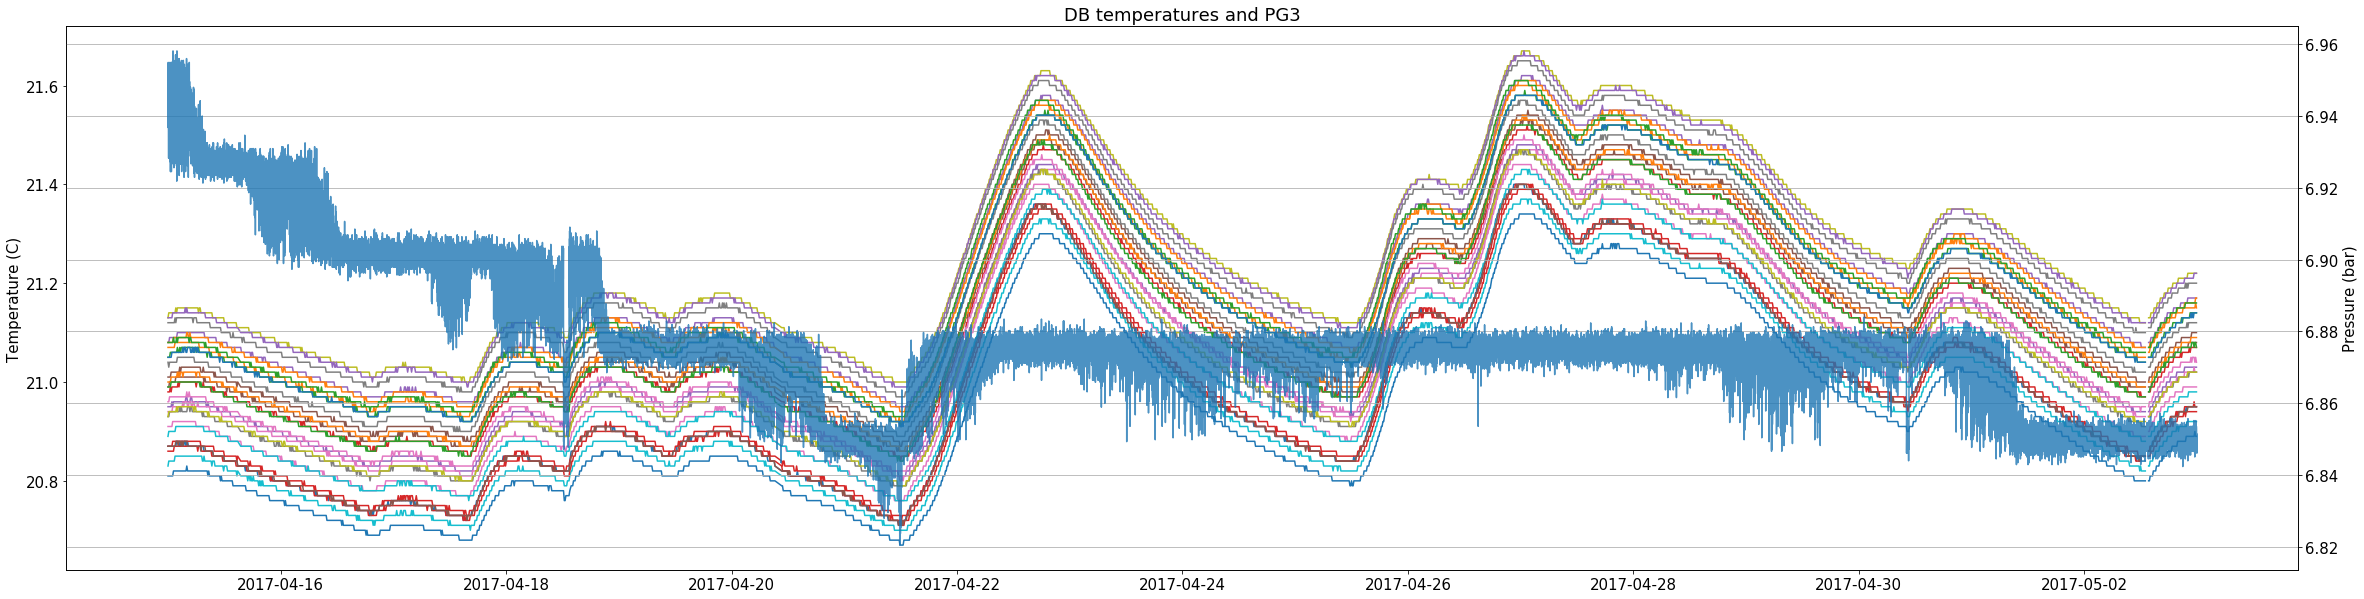

In [70]:
fig, ax1 = plt.subplots(figsize=(40, 10))

#plt.legend(loc=2)
ax1.plot(Tt, dbs)
ax1.set_ylabel('Temperature (C)')
ax2=ax1.twinx()
ax2.plot(T, [float(v.replace(',','.')) for v in pg3],alpha=.8)
ax2.set_ylabel('Pressure (bar)')
plt.title('DB temperatures and PG3')
plt.grid(True)
plt.show()

In [62]:
np.array([float(v.replace(',','.')) for v in pg3])

array([ 6.942719,  6.937912,  6.950729, ...,  6.851395,  6.84819 ,
        6.848724])

NameError: name 'r3645' is not defined

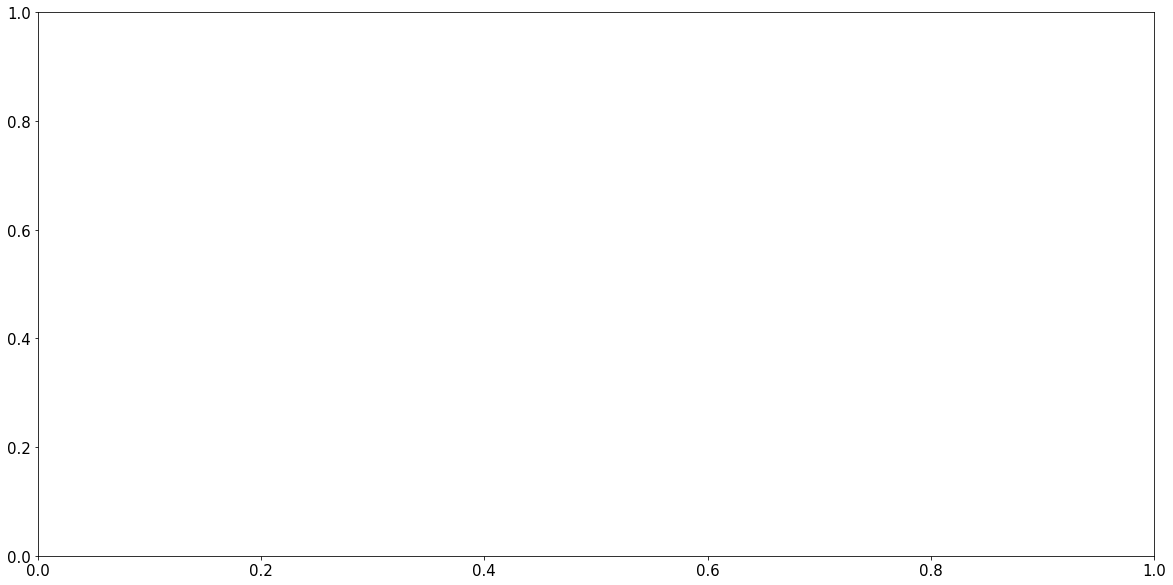

In [57]:
fig, ax1 = plt.subplots(figsize=(20, 10))
#ax1.errorbar(TIME[1:], -np.array(LAMBDA)[1:], yerr=ELAMBDA[1:], linestyle='none', fmt='o', c='r')
#r3741 = (TIME, -np.array(LAMBDA), ELAMBDA)
#r3741 = (TIME[1:], -np.array(LAMBDA)[1:], ELAMBDA[1:])
ax1.errorbar(r3645[0], r3645[1], yerr=r3645[2], linestyle='none', fmt='o', c='r', label='3645')
ax1.errorbar(r3715[0], r3715[1], yerr=r3715[2], linestyle='none', fmt='o', c='g', label='3715')
ax1.errorbar(r3724[0], r3724[1], yerr=r3724[2], linestyle='none', fmt='o', c='b', label='3724')
ax1.errorbar(r3733[0], r3733[1], yerr=r3733[2], linestyle='none', fmt='o', c='black', label='3733')
ax1.errorbar(r3741[0], r3741[1], yerr=r3741[2], linestyle='none', fmt='o', c='gold', label='3741')

plt.legend(loc=2)
ax1.set_ylabel('Lifetime (mus)')
ax2=ax1.twinx()
ax2.plot(Tt, dbs, alpha=.2)
ax2.set_ylabel('Temperature (C)')
plt.title('db temperature and lifetime')
plt.grid(True)
plt.show()